# Projeto 1 - Ciência dos Dados

Nome: Alexandre Santarossa

Nome: Lucas Novais

Nome: Marcelo Neves

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [1]:
%matplotlib inline
import math
import pandas as pd
import matplotlib.pyplot as plt
import os
from numpy import arange
import pandas as pd
from IPython.display import display
pd.options.display.max_rows = 13

In [2]:
#função de tratamento de textos
import re 

#função para limpar texto
def cleanup(text):
    
    punctuation = '[!-.:?;]'
    pattern = re.compile(punctuation)
    text_subbed = re.sub(pattern, '', text)
    return text_subbed


#Função para remover palavras irrelevantes para a analise
def remove_palavras(fr):
    lista_remover = ['de', 'a', 'o', 'da', 'do', 'e', 'em','que', 'para', 'no', 'na','com','as','os','dos','das','nesta','um','uma','uns','umas','por','aos','à','ao']
    result = [palavra for palavra in fr if palavra not in lista_remover]
    return(result)


#função que transforma lista de frases em tabela relativa das palavras contidas na lista
def formatador_tabela_rel(text):
    
    pal_teste = []
    
    for frase in text:
        bleble = str(frase)
        bleble = cleanup(bleble.lower())
        blabla = remove_palavras(bleble.split())
        for palavra in blabla:
            pal_teste.append(palavra)
            
    serie_test = pd.Series(pal_teste).value_counts(True)
    
    return serie_test


# função que transforma lista de frases em tabela absoluta das palavras contidas na lista
def formatador_tabela_abs(text):
    
    pal_teste = []
    
    for frase in text:
        bleble = str(frase)
        bleble = cleanup(bleble.lower())
        blabla = remove_palavras(bleble.split())
        for palavra in blabla:
            pal_teste.append(palavra)
            
    serie_test = pd.Series(pal_teste).value_counts() 
    
    return serie_test


#função que recebe uma lista com as palavras da notícia e retorna o índice da categoria com maior probabiblidade de classificar a notícia, -> 0:Outros  1:Política  2:Mercado
def calcula_prob_dada_modalidade(noticia, tabela_abs_todas, tabela_abs_out, tabela_abs_pol, tabela_abs_fin):
    
    noticia = remove_palavras(noticia.split())
    
    PFraseDadoOut = 1
    PFraseDadoPol = 1
    PFraseDadoFin = 1
    
    soma_out = sum(tabela_abs_out)
    soma_pol = sum(tabela_abs_pol)
    soma_fin = sum(tabela_abs_fin)
    
    for palavra in noticia:
        #Suavização de LaPlace
        if palavra not in tabela_abs_out:
            Ppal = 1/(soma_out+len(tabela_abs_todas))
            
        else:
            Ppal = (tabela_abs_out[palavra]+1)/(soma_out+len(tabela_abs_todas))
        
        PFraseDadoOut = PFraseDadoOut*Ppal
        
    for palavra in noticia:
        #Suavização de LaPlace
        if palavra not in tabela_abs_pol:
            Ppal = 1/(soma_pol+len(tabela_abs_todas))
        else:
            Ppal = (tabela_abs_pol[palavra]+1)/(soma_pol+len(tabela_abs_todas))
        
        PFraseDadoPol = PFraseDadoPol*Ppal
            
    for palavra in noticia:
        #Suavização de LaPlace
        if palavra not in tabela_abs_fin:
            Ppal = 1/(soma_fin+len(tabela_abs_todas))
        else:
            Ppal = (tabela_abs_fin[palavra]+1)/(soma_fin+len(tabela_abs_todas))
        
        PFraseDadoFin = PFraseDadoFin*Ppal
        
    
    #índices-> 0:Outros  1:Política  2:Mercado
    lista = [Poutros*PFraseDadoOut, Ppolit*PFraseDadoPol, Pfinan*PFraseDadoFin]
    
    maior = max(lista)
    
    indice = lista.index(maior)
    
    return(indice)



#Função que dado DataFrame de noticias e as tabelas absolutas(Categorias+Todas), devolve uma lista dos percentuais [acertos, erros] do classificador
def verifica(teste, tabela_abs_todas, tabela_abs_out, tabela_abs_pol, tabela_abs_fin):
    
    acertos = 0
    erros = 0
    
    for i in range(1,len(teste)): 
        
        taget = teste.iloc[i,5]
        
        if taget == 'Mercado':
            taget = 2
            
        elif taget == 'Política':
            taget = 1
            
        elif taget == 'Outros':
            taget = 0
            
        
        texto1= teste.iloc[i,1]
        texto2= teste.iloc[i,2]
        texto= f"{texto1}" + ' ' + f"{texto2}"
        
        verif = calcula_prob_dada_modalidade(texto, tabela_abs_todas, tabela_abs_out, tabela_abs_pol, tabela_abs_fin)
        
        if verif == taget:
            acertos+=1
        else:
            erros+=1
    
    acertos_pc = round((acertos/len(teste)*100), 2)
    erros_pc = round((erros/len(teste)*100), 2)
    
    
    return ([acertos_pc, erros_pc])



#Função que recebe um DataFrame(todas as notícias), separa ele em treino e teste (proporção 3:2) e devolve uma lista dos percentuais [acertos, erros] do classificador
#O argumento opcional 'limite' apenas foi usado para limitar os prints (max=10) da função quando usada dentro da função repetidor
def funcao_mae(dataframe, limite=-1):
    
    num = int(len(dataframe)*3/5)
    treino = dataframe.sample(n=num)
    testando = pd.concat([dataframe,treino]).drop_duplicates(keep=False)

    
    #Separando Targets
    outros = treino.loc[treino['Target']=='Outros',:]
    polit = treino.loc[treino['Target']=='Política',:]
    finan = treino.loc[treino['Target']=='Mercado',:]
    
    
    #Obtendo textos das notícias
    frases_outros = outros['Titulo'].tolist() + outros['PrimeiroParag'].tolist()
    frases_polit = polit['Titulo'].tolist() + polit['PrimeiroParag'].tolist()
    frases_finan = finan['Titulo'].tolist() + finan['PrimeiroParag'].tolist()


    #tabelas relativas das palavras em cada categoria
    tabela_abs_out = formatador_tabela_abs(frases_outros)
    tabela_abs_pol = formatador_tabela_abs(frases_polit)
    tabela_abs_fin = formatador_tabela_abs(frases_finan)
    
    
    titulo_todas = todas['Titulo'].tolist()
    pp_todas = todas['PrimeiroParag'].tolist()
    todas_juntas = titulo_todas + pp_todas
    tabela_abs_todas = formatador_tabela_abs(todas_juntas)
    
    
    Poutros = len(tabela_abs_out)/len(tabela_abs_todas)
    Ppolit = len(tabela_abs_pol)/len(tabela_abs_todas)
    Pfinan = len(tabela_abs_fin)/len(tabela_abs_todas)
    
    
    resultado = verifica(testando,tabela_abs_todas,tabela_abs_out,tabela_abs_pol,tabela_abs_fin)
    
    if limite<10:
        print('Acertos:{}% -- Erros:{}%'.format(resultado[0], resultado[1]))
    if limite==10:
        print('...')
    if limite==30:
        print('Calculando o restante dos percentuais...')
    if limite==100:
        print('...')
        
    return(resultado)



#Função que recebe um dataframe(df) e um inteiro (n) e retorna o percentual médio dos erros e acertos do classificador aprendendo e testando n vezes, plota um gráfico de densidade dos acertos
def repetidor(df,n):
    
    acertos_total = 0
    erros_total = 0
    
    dados_obtidos = []
    
    for i in range(0,n):
        
        l1 = funcao_mae(df,i)
        
        acertos_total+=l1[0]
        erros_total+=l1[1]
        
        dados_obtidos.append(l1[0])
        
    acertos_totalm = round(acertos_total/n,2)
    erros_totalm = round(erros_total/n, 2)
    
    print(' ')
    print('Percentual médio de acertos: {}%'.format(acertos_totalm))
    print('Percentual médio de erros: {}%'.format(erros_totalm))
    
    limMenor = round(min(dados_obtidos))
    limMaior = round(max(dados_obtidos))
    
    dados_obtidos = pd.Series(dados_obtidos).to_frame()
    
    faixa = arange(limMenor,limMaior,0.25)

    fig = plt.figure(figsize=(18, 10))
    plot = plt.hist(dados_obtidos, bins=faixa, density=True, 
                    color='turquoise', edgecolor='white', alpha=1)
    plt.xlabel('% de Acertos')
    plt.ylabel('Densidade')
    plt.title('Qualidade do Classificador - {} amostras'.format(n))
    plt.xlim(limMenor-1, limMaior+1)

    return()


In [3]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\home\Desktop\insper\2022_1\CDados\Projeto_1\22-1a-cd-p1-grupo_alexandrers3


Carregando a base de dados com as notícias classificadas manualmente:

In [4]:
filename = 'dados.xlsx'

#Todas as notícias
todas = pd.read_excel(filename, sheet_name = 'Planilha1')

#Nomeando Targets
todas['Target'] = todas['Target'].astype('category')
todas.Target.cat.categories = ['Mercado', 'Política', 'Outros']
todas.Target = pd.Categorical(todas.Target, categories=['Mercado', 'Política', 'Outros'], ordered=False)
todas['Target'].value_counts(True)*100

Mercado     60.466667
Outros      22.600000
Política    16.933333
Name: Target, dtype: float64

In [5]:
#Notícias de treino
train = pd.read_excel(filename, sheet_name = 'Treinamento')
train.head(5)

,Categoria,Titulo,PrimeiroParag,Data,Pagina,Target
0,Ações,Quais ações e fundos de ações os grandes inves...,"Em agosto, o Ibovespa teve uma perda de 3,44%....",17/09/2020 - 12:03,142,1
1,Agro Times,Estiagem: ministra da Agricultura diz que visi...,"A ministra da Agricultura, Tereza Cristina, es...",13/01/2022 - 11:00,25,2
2,Agronegócio,JBS firma parceria com BB para estimular regul...,A fim de facilitar a contratação de crédito po...,24/02/2022 - 16:20,9,2
3,Agronegócio,Governo estuda remanejar recursos do Plano Saf...,O governo federal estuda remanejar os recursos...,27/08/2021 - 20:10,54,2
4,Agronegócio,“Granja do futuro” tem ar-condicionado para av...,Uma das maiores companhias de alimentos do mun...,22/06/2021 - 12:10,67,3


In [6]:
#Nomeando Targets
train['Target'] = train['Target'].astype('category')
train.Target.cat.categories = ['Mercado', 'Política', 'Outros']
train.Target = pd.Categorical(train.Target, categories=['Mercado', 'Política', 'Outros'], ordered=False)

In [7]:
#Notícias de teste
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Categoria,Titulo,PrimeiroParag,Data,Pagina,Target
0,Agricultura,Corte de recursos no próximo plano safra preoc...,"O próximo Plano Safra do Governo Federal, a se...",22/04/2021 - 17:29,82,2
1,Agronegócio,Banco do Brasil reforça linhas de crédito rura...,O Banco do Brasil (BBAS3) anunciou hoje (10) a...,10/11/2020 - 13:15,127,3
2,Agronegócio,Bolsonaro diz que safra brasileira chegará a 3...,O presidente Jair Bolsonaro disse hoje (28) qu...,28/06/2021 - 14:24,66,2
3,Agronegócio,Exportador de café Terra Forte tem plano de re...,O conglomerados exportador de café Terra Forte...,04/12/2020 - 20:30,122,2
4,Agronegócio,Agro versus Bradesco: além do churrasquinho gr...,"Segunda (3), em paralelo ao movimento “Segunda...",31/12/2021 - 11:45,27,3


In [8]:
#Nomeando Targets
test['Target'] = test['Target'].astype('category')
test.Target.cat.categories = ['Mercado', 'Política', 'Outros']
test.Target = pd.Categorical(test.Target, categories=['Mercado', 'Política', 'Outros'], ordered=False)

In [9]:
todas

,Categoria,Titulo,PrimeiroParag,Data,Pagina,Target
0,Ações,Quais ações e fundos de ações os grandes inves...,"Em agosto, o Ibovespa teve uma perda de 3,44%....",17/09/2020 - 12:03,142,Mercado
1,Bancos,"Caixa tem lucro líquido de R$ 3,218 bi no 4º t...",A Caixa Econômica Federal anunciou lucro líqui...,24/02/2022 - 14:39,9,Mercado
2,Bancos,"Itaú (ITUB4), Bradesco (BBDC4), Santander (SAN...","O Itaú (ITUB4), Bradesco (BBDC4), Santander (...",16/02/2022 - 15:21,12,Mercado
3,Bancos,Banco do Brasil (BBAS3) espera lucrar até R$ 2...,O Banco do Brasil (BBAS3) considera lucrar ent...,14/02/2022 - 18:58,14,Mercado
4,Bancos,Retração de ações de bancos antecipa PIB fraco...,Os lucros dos grandes bancos brasileiros devem...,27/12/2021 - 13:01,28,Mercado
...,...,...,...,...,...,...
1495,Setor Imobiliário,"Banco do Brasil (BBAS3) vende mais de 3,2 mil ...",O Banco do Brasil (BBAS3) está vendendo cerca ...,18/03/2022 - 13:58,1,Outros
1496,Setor Imobiliário,"Itaú, Santander e BB levam mais de 100 imóveis...","A Biasi Leilões, uma das principais empresas d...",27/07/2021 - 16:42,62,Outros
1497,Sucroenergia,"Com prazo de 20 anos e deságio de 80%, Grupo D...",Os produtores de cana credores do Grupo Diné s...,13/01/2022 - 13:48,24,Outros
1498,Sucroenergia,Franqueamento de áreas de cana ajudou deixar A...,Quando os problemas da Atvos se avolumaram na ...,20/08/2020 - 11:42,150,Outros


___
## Classificador automático


<h5>Escolhemos o tema de 'Banco do Brasil', banco estatal que esta diretamente ligado a economia do governo brasileiro, por aparecer na mídia lincado diretamente com a política do Brasil e com sua ligação com o mercado mundial, temas presentes em muitas notícias pesquisadas e que utilizamos como Target para o nosso projeto.</h5>

___
### Montando um Classificador Naive-Bayes

<h5>Considerando apenas as mensagens da planilha Treinamento, vamos ensinar o classificador.</h5>

In [18]:
#Separando Targets
outros = train.loc[train['Target']=='Outros',:]
polit = train.loc[train['Target']=='Política',:]
finan = train.loc[train['Target']=='Mercado',:]

In [19]:
#Obtendo textos das notícias
frases_outros = outros['Titulo'].tolist() + outros['PrimeiroParag'].tolist()
frases_polit = polit['Titulo'].tolist() + polit['PrimeiroParag'].tolist()
frases_finan = finan['Titulo'].tolist() + finan['PrimeiroParag'].tolist()

In [20]:
#Obtendo textos das notícias
titulo_test = test['Titulo'].tolist()
pp_test = test['PrimeiroParag'].tolist()
titulo_train = train['Titulo'].tolist()
pp_train = train['PrimeiroParag'].tolist()
titulo_todas = todas['Titulo'].tolist()
pp_todas = todas['PrimeiroParag'].tolist()

todas_test = titulo_test + pp_test
todas_train = titulo_train + pp_train
todas_juntas = titulo_todas + pp_todas

In [21]:
#tabelas relativas das palavras em cada categoria
tabela_abs_outros = formatador_tabela_abs(frases_outros)
tabela_abs_polit = formatador_tabela_abs(frases_polit)
tabela_abs_finan = formatador_tabela_abs(frases_finan)

In [22]:
#tabelas de todas as palavras
tabela_abs_todas = formatador_tabela_abs(todas_juntas)
tabela_rel_todas = formatador_tabela_rel(todas_juntas)

In [23]:
# Probabilidade das categorias7
Poutros = len(tabela_abs_outros)/len(tabela_rel_todas)
Ppolit = len(tabela_abs_polit)/len(tabela_rel_todas)
Pfinan = len(tabela_abs_finan)/len(tabela_rel_todas)

In [24]:
#frase de teste Retorno-> 0:Outros  1:Política  2:Mercado
noticia1 = 'Governo aprova novo arcabouço para contabilidade de bancos, alinhado ao IFRS 9'
print(calcula_prob_dada_modalidade(noticia1,tabela_abs_todas,tabela_abs_outros,tabela_abs_polit,tabela_abs_finan))

1


___
### Verificando a performance do Classificador

<h5>Agora vamos testar o classificador com a base de Testes.</h5>

In [25]:
aa = verifica(test,tabela_abs_todas,tabela_abs_outros,tabela_abs_polit,tabela_abs_finan)
print('Acertos:{}% -- Erros:{}%'.format(aa[0], aa[1]))

Acertos:72.67% -- Erros:27.17%


___
### Concluindo

<h5>Após a implementação de um classificador Naive-Beyes e fazendo os devidos testes temos uma taxa de sucesso superior a 70% demonstrando a qualidade dos Targets escolhidos no processo e sua repetição presente nas notícias encontradas.</h5>

___
### Qualidade do Classificador a partir de novas separações das notícias entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [ ]:
repetidor(todas, 20)

Acertos:73.0% -- Erros:26.83%
Acertos:72.17% -- Erros:27.67%
Acertos:71.5% -- Erros:28.33%
Acertos:71.67% -- Erros:28.17%
Acertos:74.67% -- Erros:25.17%
Acertos:71.67% -- Erros:28.17%
Acertos:73.83% -- Erros:26.0%
Acertos:70.5% -- Erros:29.33%
Acertos:74.33% -- Erros:25.5%
Acertos:74.83% -- Erros:25.0%
...


Acertos:73.33% -- Erros:26.5%
Acertos:73.67% -- Erros:26.17%
Acertos:73.17% -- Erros:26.67%
Acertos:73.67% -- Erros:26.17%
Acertos:73.17% -- Erros:26.67%
Acertos:73.17% -- Erros:26.67%
Acertos:75.33% -- Erros:24.5%
Acertos:76.83% -- Erros:23.0%
Acertos:74.5% -- Erros:25.33%
Acertos:74.5% -- Erros:25.33%
...
Calculando o restante dos percentuais...
...
 
Percentual médio de acertos: 73.72%
Percentual médio de erros: 26.11%


()

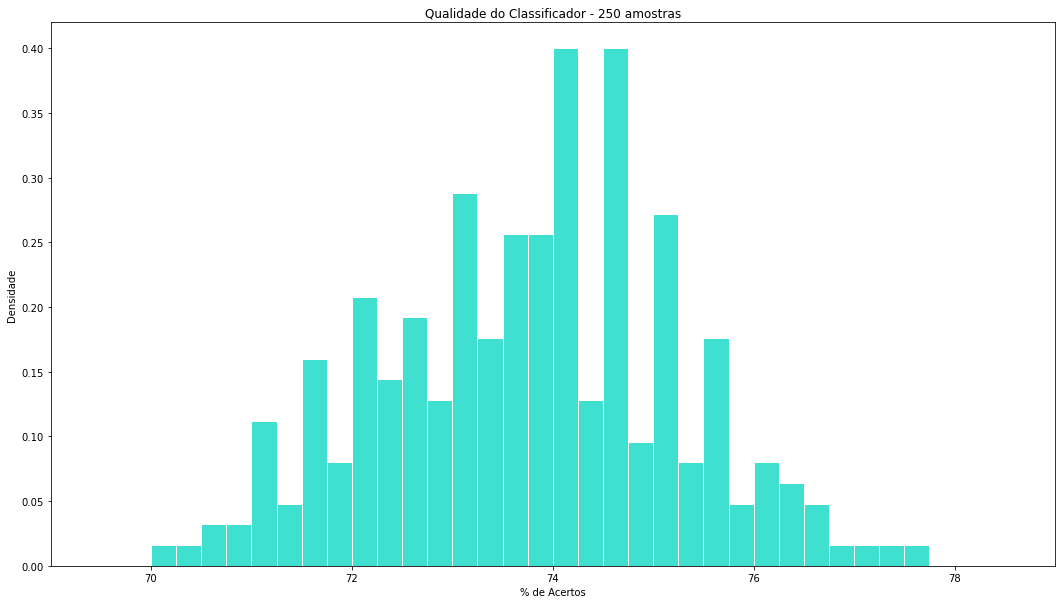

In [37]:
repetidor(todas, 250)

Acertos:69.83% -- Erros:30.0%
Acertos:71.5% -- Erros:28.33%
Acertos:74.17% -- Erros:25.67%
Acertos:75.5% -- Erros:24.33%
Acertos:70.5% -- Erros:29.33%
Acertos:75.33% -- Erros:24.5%
Acertos:76.83% -- Erros:23.0%
Acertos:72.17% -- Erros:27.67%
Acertos:74.67% -- Erros:25.17%
Acertos:71.33% -- Erros:28.5%
...
Calculando o restante dos percentuais...
...
 
Percentual médio de acertos: 73.68%
Percentual médio de erros: 26.15%


()

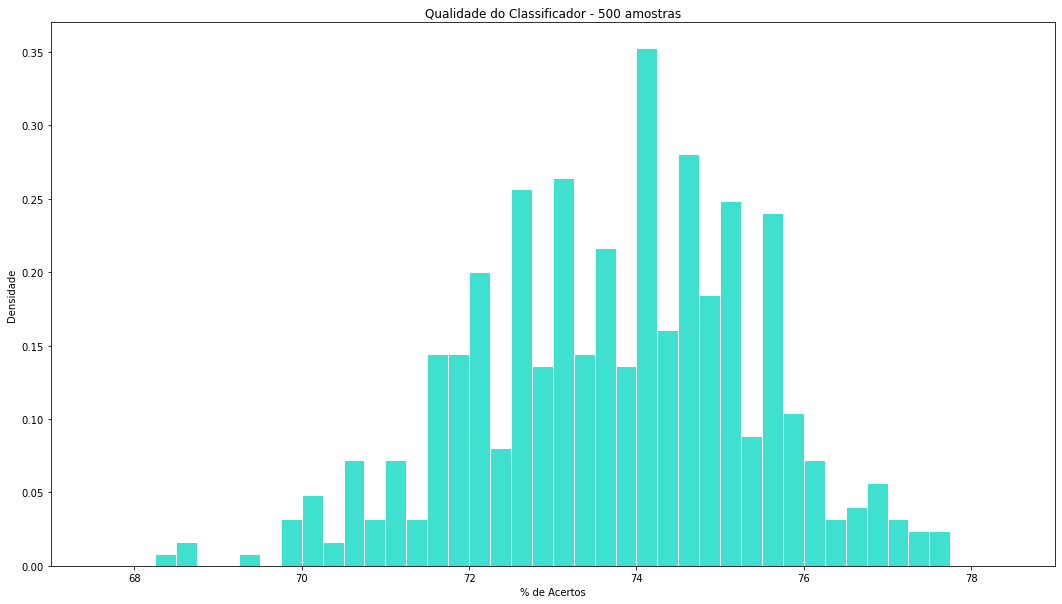

In [38]:
repetidor(todas, 500)

Acertos:72.83% -- Erros:27.0%
Acertos:76.5% -- Erros:23.33%
Acertos:77.33% -- Erros:22.5%
Acertos:70.17% -- Erros:29.67%
Acertos:73.83% -- Erros:26.0%
Acertos:71.67% -- Erros:28.17%
Acertos:72.33% -- Erros:27.5%
Acertos:76.0% -- Erros:23.83%
Acertos:70.17% -- Erros:29.67%
Acertos:76.83% -- Erros:23.0%
...
Calculando o restante dos percentuais...
...
 
Percentual médio de acertos: 73.83%
Percentual médio de erros: 26.01%


()

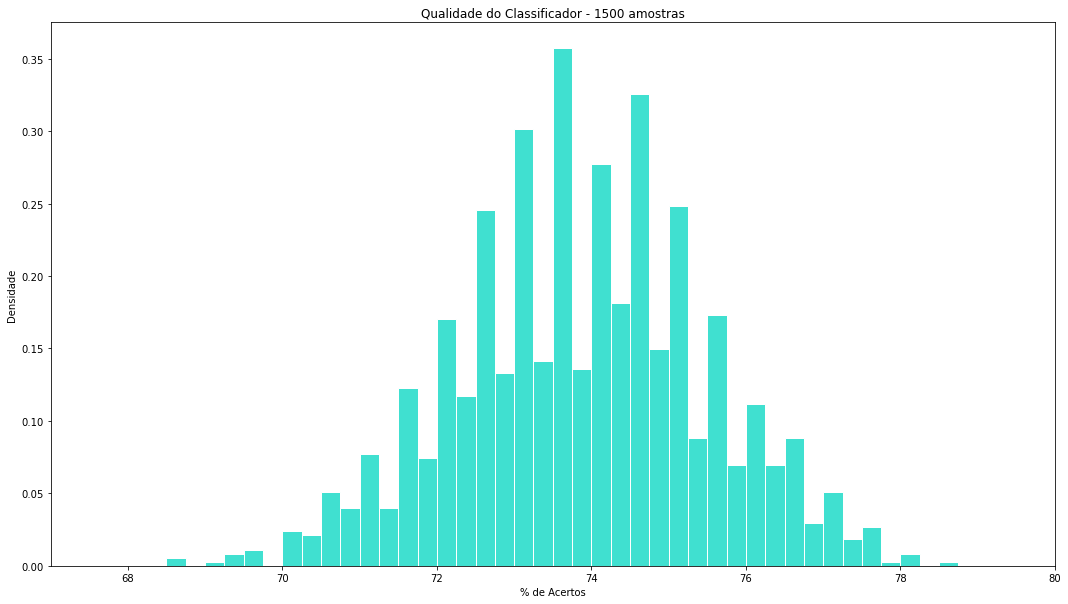

In [39]:
repetidor(todas, len(todas))

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nas notícias. Ex: stemming, lemmatization, stopwords
* CONSIDEROU mais de duas caterogias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por caterogia (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**